In [1]:
import pandas as pd
import torch
import numpy as np
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from nltk.sentiment import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


C:\Users\count\anaconda3\envs\cuda_test2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Disable Warnings & Parallelism for Better Performance
warnings.filterwarnings("ignore", category=UserWarning, module="transformers")
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # Prevent tokenizer multiprocessing overhead

# Set Device: Use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load Pre-Trained Models
sarcasm_model_name = "cardiffnlp/twitter-roberta-base-irony"
sarcasm_tokenizer = AutoTokenizer.from_pretrained(sarcasm_model_name)
sarcasm_model = AutoModelForSequenceClassification.from_pretrained(sarcasm_model_name).to(device)

roberta_model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_model_name)
roberta_model = AutoModelForSequenceClassification.from_pretrained(roberta_model_name).to(device)

sarcasm_detector = pipeline("text-classification", model=sarcasm_model, tokenizer=sarcasm_tokenizer, device=0 if torch.cuda.is_available() else -1)

# Initialize VADER Sentiment Analyzer (always CPU)
sia = SentimentIntensityAnalyzer()
print("Sentiment Models & Sarcasm Detector Loaded and Assigned to:", device)


Using device: cuda


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


Sentiment Models & Sarcasm Detector Loaded and Assigned to: cuda


In [3]:
def get_sentiment_predictions(text):
    """Gets sentiment predictions from RoBERTa-Twitter and VADER."""
    sentiment_results = {}

    # RoBERTa-Twitter Model
    inputs = roberta_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = roberta_model(**inputs)

    scores = outputs.logits.softmax(dim=-1).cpu().numpy().flatten()
    label_map = ["Negative", "Neutral", "Positive"]
    prediction = label_map[scores.argmax()]

    sentiment_results["RoBERTa-Twitter"] = {
        "prediction": prediction,
        "score": scores[label_map.index(prediction)]
    }

    # VADER Sentiment Analysis
    vader_scores = sia.polarity_scores(text)
    vader_label = "Positive" if vader_scores['compound'] >= 0.05 else "Negative" if vader_scores['compound'] <= -0.05 else "Neutral"

    sentiment_results["VADER"] = {
        "prediction": vader_label,
        "score": vader_scores['compound']
    }

    return sentiment_results

In [4]:
# def standardize_scores(roberta_score, vader_score):
#     """Brings different rating scales to a common 0 to 1 scale."""
#     standardized_roberta = (roberta_score - 0.5) * 2  # Scale to match VADER range (-1 to 1)  # RoBERTa already ranges from 0 to 1
#     standardized_vader = (vader_score + 1) / 2  # Convert VADER's -1 to 1 scale to 0 to 1
#     return standardized_roberta, standardized_vader

In [5]:
def min_max_scaling(x, min_val, max_val):
    """Scales values to a range of [-1, 1] using min-max scaling."""
    return 2 * ((x - min_val) / (max_val - min_val)) - 1

# def standardize_scores(roberta_score, vader_score, roberta_min, roberta_max, vader_min, vader_max):
#     """Standardizes scores to the same scale of [-1,1] using min-max scaling."""
#     standardized_roberta = min_max_scaling(roberta_score, roberta_min, roberta_max)
#     standardized_vader = min_max_scaling(vader_score, vader_min, vader_max)
#     return standardized_roberta, standardized_vader

def standardize_scores(roberta_score, vader_score, roberta_min, roberta_max, vader_min, vader_max, sarcasm_prob):
    """Standardizes scores to the same scale of [-1,1] using min-max scaling and adjusts for sarcasm."""
    standardized_roberta = min_max_scaling(roberta_score, roberta_min, roberta_max)
    standardized_vader = min_max_scaling(vader_score, vader_min, vader_max)
    
    # Adjust for sarcasm
    standardized_roberta = adjust_sentiment_for_sarcasm(standardized_roberta, sarcasm_prob)
    
    return standardized_roberta, standardized_vader

def adjust_sentiment_for_sarcasm(roberta_score, sarcasm_prob):
    """Adjusts RoBERTa sentiment score based on sarcasm probability."""
    if sarcasm_prob > 0.95:  # Strong sarcasm → Full sentiment flip
        return -roberta_score
    elif sarcasm_prob > 0.90:  # Moderate sarcasm → Reduce confidence
        return roberta_score * (1 - sarcasm_prob)
    return roberta_score  # No sarcasm detected → Keep original score

def detect_sarcasm_batch(text_list, max_length=512):
    """
    Detect sarcasm probabilities for a list of texts using batch processing.
    Truncates inputs to prevent token overflow issues on GPU.
    """
    # Truncate long texts
    truncated = [text[:max_length] for text in text_list]

    # Run pipeline on batch
    results = sarcasm_detector(truncated, truncation=True, padding=True)

    # Return sarcasm probabilities
    sarcasm_probs = [
        r['score'] if r['label'].lower() == 'irony' else 1 - r['score'] for r in results
    ]
    return sarcasm_probs
    

In [6]:
def compute_sentiment_agreement(df):
    """Computes the agreement percentage between RoBERTa and VADER sentiment classifications and breakdown of agreement/disagreement cases."""
    agreement = (df["RoBERTa-Twitter_sentiment"] == df["VADER_sentiment"]).mean() * 100
    print(f"✅ Sentiment Agreement: {agreement:.2f}%")
    
    # Compute agreement breakdown
    sentiment_comparison = df.groupby(["RoBERTa-Twitter_sentiment", "VADER_sentiment"]).size().unstack(fill_value=0)
    print("\n📊 Sentiment Agreement Breakdown:")
    print(sentiment_comparison)
    
    # Compute sarcasm percentage
    sarcasm_percentage = (df["Sarcasm_Prob"] > 0.8).mean() * 100
    print(f"📌 Percentage of samples with Sarcasm_Prob > 0.8: {sarcasm_percentage:.2f}%")

In [7]:
# File paths and dataset names
filelist = [
    './datasets/__sprint2_filtered_gameplay_review_set.csv',
    './datasets/__sprint2_filtered_functionality_review_set.csv',
    './datasets/__sprint2_filtered_usability_review_set.csv'
]

In [8]:
def process_and_save_sentiment(file_path):
    """Processes a CSV file by computing sentiment scores from RoBERTa-Twitter and VADER, then standardizes them with sarcasm adjustment."""
    if not os.path.exists(file_path):
        print(f"❌ ERROR: File not found: {file_path}")
        return

    df = pd.read_csv(file_path, encoding='utf-8') #.head(200)
    df = df.dropna(subset=['tokenized_sentence'])
    df['tokenized_sentence'] = df['tokenized_sentence'].astype(str)
    df = df[df['tokenized_sentence'].str.strip() != ""]

    batch_size = 32
    num_batches = int(np.ceil(len(df) / batch_size))
    sentiment_scores = {"RoBERTa-Twitter": [], "VADER": [], "Sarcasm_Prob": []}
    sentiment_predictions = {"RoBERTa-Twitter": [], "VADER": []}

    for i in range(num_batches):
        start_idx, end_idx = i * batch_size, min((i + 1) * batch_size, len(df))
        batch_sentences = df.iloc[start_idx:end_idx]["tokenized_sentence"].tolist()

        batch_results = [get_sentiment_predictions(text) for text in batch_sentences]
        sarcasm_probs = detect_sarcasm_batch(batch_sentences)

        for result, sarcasm_prob in zip(batch_results, sarcasm_probs):
            sentiment_predictions["RoBERTa-Twitter"].append(result["RoBERTa-Twitter"]["prediction"])
            sentiment_scores["RoBERTa-Twitter"].append(result["RoBERTa-Twitter"]["score"])
            sentiment_predictions["VADER"].append(result["VADER"]["prediction"])
            sentiment_scores["VADER"].append(result["VADER"]["score"])
            sentiment_scores["Sarcasm_Prob"].append(sarcasm_prob)

    df["RoBERTa-Twitter_sentiment"] = sentiment_predictions["RoBERTa-Twitter"]
    df["RoBERTa-Twitter_score"] = sentiment_scores["RoBERTa-Twitter"]
    df["VADER_sentiment"] = sentiment_predictions["VADER"]
    df["VADER_score"] = sentiment_scores["VADER"]
    df["Sarcasm_Prob"] = sentiment_scores["Sarcasm_Prob"]

    base_name = os.path.splitext(file_path)[0]
    output_file_path = os.path.join(os.path.dirname(file_path), f"{os.path.basename(base_name)}_with_sentiment_scores.csv")
    df.to_csv(output_file_path, index=False)
    print(f"✅ Processed and saved sentiment scores to: {output_file_path}")

    # Load the newly created file and standardize the scores
    df = pd.read_csv(output_file_path)
    roberta_min, roberta_max = df["RoBERTa-Twitter_score"].min(), df["RoBERTa-Twitter_score"].max()
    vader_min, vader_max = df["VADER_score"].min(), df["VADER_score"].max()

    df[["RoBERTa-Twitter_score_standardized", "VADER_score_standardized"]] = df.apply(
        lambda row: standardize_scores(row["RoBERTa-Twitter_score"], row["VADER_score"], roberta_min, roberta_max, vader_min, vader_max, row["Sarcasm_Prob"]),
        axis=1, result_type="expand")

    output_standardized_file_path = os.path.join(os.path.dirname(file_path), f"{os.path.basename(base_name)}_with_sentiment_scores_standardized.csv")
    df.to_csv(output_standardized_file_path, index=False)
    print(f"✅ Standardized sentiment scores saved to: {output_standardized_file_path}")

    compute_sentiment_agreement(df)

filelist = ["./datasets/__sprint2_filtered_gameplay_review_set.csv", 
            "./datasets/__sprint2_filtered_functionality_review_set.csv", 
            "./datasets/__sprint2_filtered_usability_review_set.csv"]

for file_path in filelist:
    process_and_save_sentiment(file_path)

print("✅ Sentiment scores saved successfully!")



Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


✅ Processed and saved sentiment scores to: ./datasets\__sprint2_filtered_gameplay_review_set_with_sentiment_scores.csv
✅ Standardized sentiment scores saved to: ./datasets\__sprint2_filtered_gameplay_review_set_with_sentiment_scores_standardized.csv
✅ Sentiment Agreement: 61.30%

📊 Sentiment Agreement Breakdown:
VADER_sentiment            Negative  Neutral  Positive
RoBERTa-Twitter_sentiment                             
Negative                      15193     6106      6686
Neutral                        6333    19513     13187
Positive                       1188     3962     24641
📌 Percentage of samples with Sarcasm_Prob > 0.8: 11.44%
✅ Processed and saved sentiment scores to: ./datasets\__sprint2_filtered_functionality_review_set_with_sentiment_scores.csv
✅ Standardized sentiment scores saved to: ./datasets\__sprint2_filtered_functionality_review_set_with_sentiment_scores_standardized.csv
✅ Sentiment Agreement: 54.05%

📊 Sentiment Agreement Breakdown:
VADER_sentiment            Nega

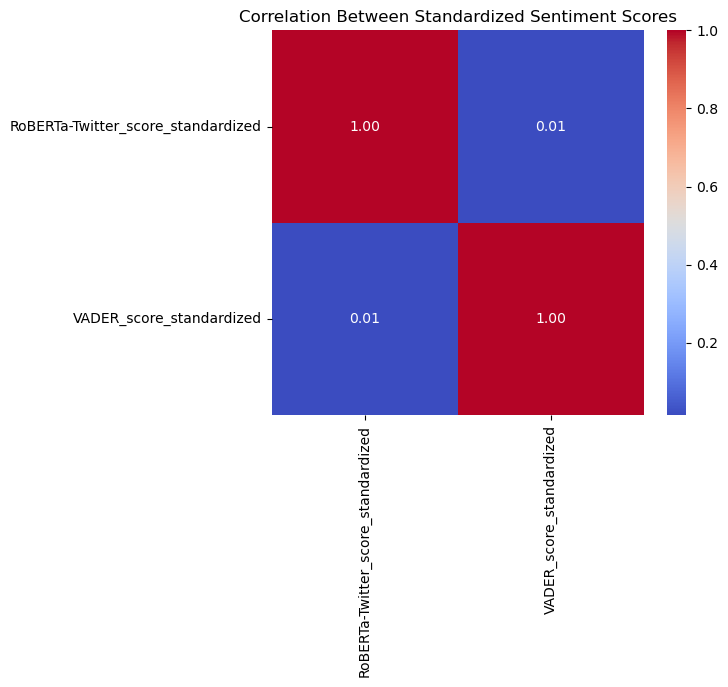

C:\Users\count\AppData\Local\Temp\ipykernel_5216\1485371234.py:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(standardized_df["RoBERTa-Twitter_score_standardized"], label="RoBERTa-Twitter (Standardized)", shade=True)
C:\Users\count\AppData\Local\Temp\ipykernel_5216\1485371234.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(standardized_df["VADER_score_standardized"], label="VADER (Standardized)", shade=True)


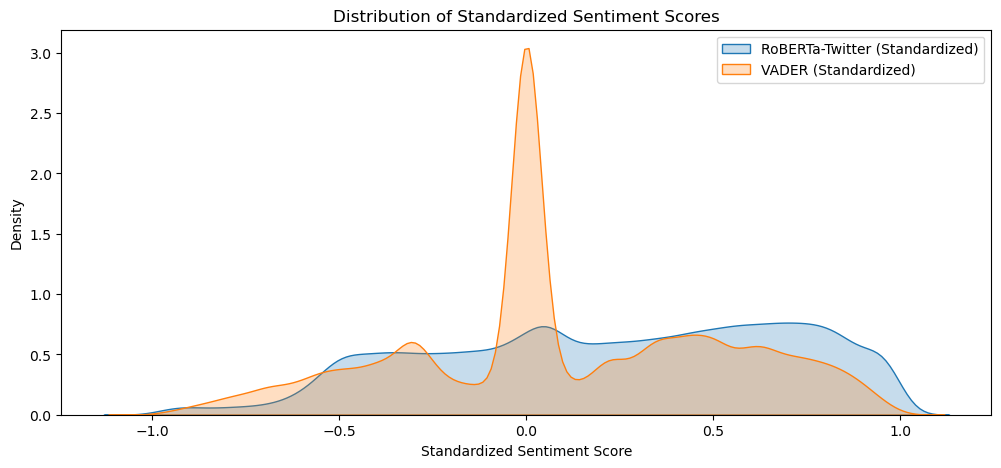

🎯 Validation and Analysis Complete!


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load all sentiment score datasets for validation
g_set = pd.read_csv("./datasets/__sprint2_filtered_gameplay_review_set_with_sentiment_scores_standardized.csv")
u_set = pd.read_csv("./datasets/__sprint2_filtered_usability_review_set_with_sentiment_scores_standardized.csv")
f_set = pd.read_csv("./datasets/__sprint2_filtered_functionality_review_set_with_sentiment_scores_standardized.csv")

# Concatenate all datasets
standardized_df = pd.concat([g_set, u_set, f_set], ignore_index=True)

# Generate a correlation heatmap
plt.figure(figsize=(6,5))
sns.heatmap(standardized_df[["RoBERTa-Twitter_score_standardized", "VADER_score_standardized"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Standardized Sentiment Scores")
plt.show()

# Plot score distributions
plt.figure(figsize=(12,5))
sns.kdeplot(standardized_df["RoBERTa-Twitter_score_standardized"], label="RoBERTa-Twitter (Standardized)", shade=True)
sns.kdeplot(standardized_df["VADER_score_standardized"], label="VADER (Standardized)", shade=True)
plt.xlabel("Standardized Sentiment Score")
plt.ylabel("Density")
plt.title("Distribution of Standardized Sentiment Scores")
plt.legend()
plt.show()

print("🎯 Validation and Analysis Complete!")

             Model  Accuracy
0            VADER  0.455562
1  RoBERTa-Twitter  0.454780


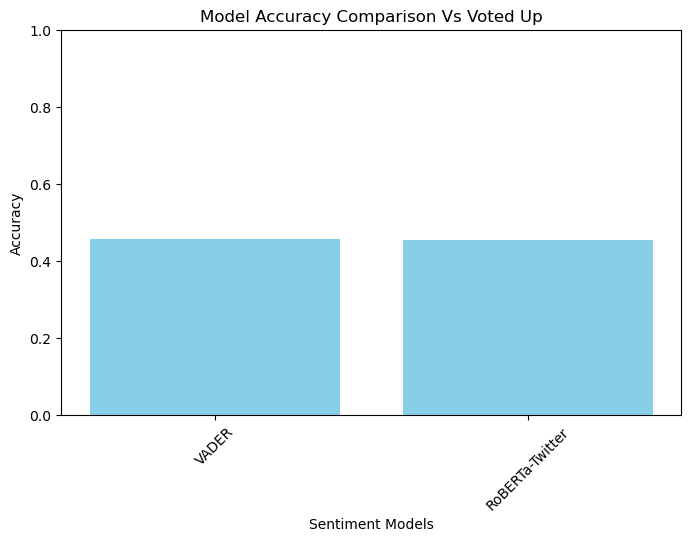

In [10]:
# Load sentiment analysis results
g_set = pd.read_csv('datasets/__sprint2_filtered_gameplay_review_set_with_sentiment_scores_standardized.csv')
u_set = pd.read_csv('datasets/__sprint2_filtered_usability_review_set_with_sentiment_scores_standardized.csv')
f_set = pd.read_csv('datasets/__sprint2_filtered_functionality_review_set_with_sentiment_scores_standardized.csv')

# Combine datasets for full analysis
df = pd.concat([g_set, u_set, f_set], ignore_index=True)
# Convert voted_up to categorical sentiment labels
df["actual_sentiment"] = df["voted_up"].apply(lambda x: "Positive" if x == 1 else "Negative")
# Compare predicted sentiment against actual sentiment
accuracy_results = {}
model_names = ["VADER", "RoBERTa-Twitter"]
for model in model_names:
    if f"{model}_sentiment" in df.columns:
        accuracy = (df[f"{model}_sentiment"] == df["actual_sentiment"]).mean()
        accuracy_results[model] = accuracy

# Convert to DataFrame for better visualization
accuracy_df = pd.DataFrame(accuracy_results.items(), columns=["Model", "Accuracy"])

# Print accuracy results
print(accuracy_df)

plt.figure(figsize=(8, 5))
plt.bar(accuracy_results.keys(), accuracy_results.values(), color='skyblue')
plt.xlabel("Sentiment Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison Vs Voted Up")
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.xticks(rotation=45)
plt.show()

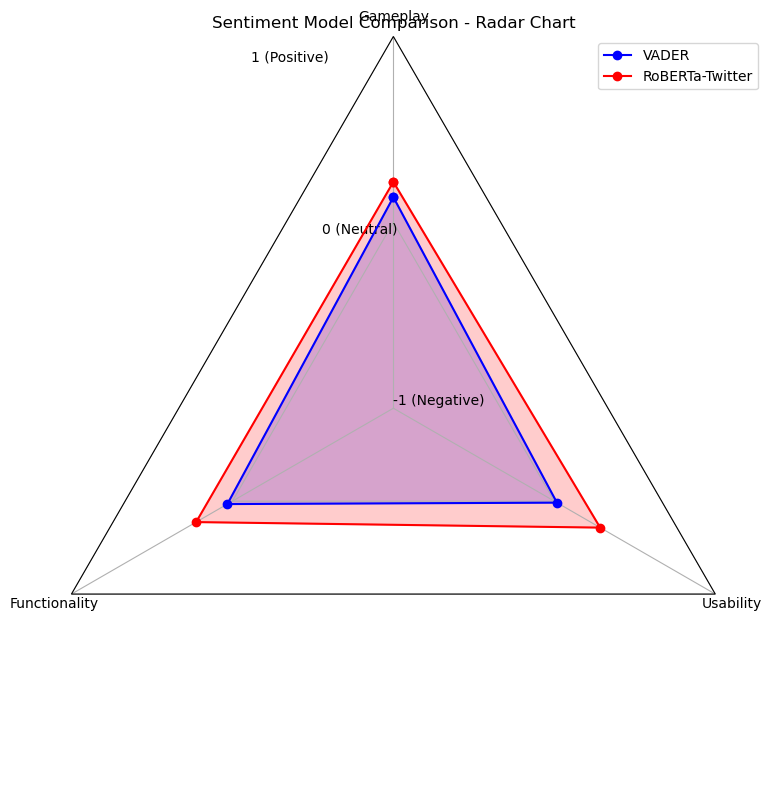

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

# ✅ File paths for datasets
file_paths = {
    "Gameplay": "datasets/__sprint2_filtered_gameplay_review_set_with_sentiment_scores_standardized.csv",
    "Functionality": "datasets/__sprint2_filtered_functionality_review_set_with_sentiment_scores_standardized.csv",
    "Usability": "datasets/__sprint2_filtered_usability_review_set_with_sentiment_scores_standardized.csv",
}

# ✅ Define sentiment models
model_names = ["VADER", "RoBERTa-Twitter"]

# ✅ Define radar chart categories
categories = ["Gameplay", "Functionality", "Usability"]
num_vars = len(categories)

# ✅ Function to create radar chart projection
def radar_factory(num_vars, frame="polygon"):
    """Create a radar chart projection."""
    theta = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    theta += [theta[0]]  # Close the shape

    class RadarTransform(PolarAxes.PolarTransform):
        def transform_path_non_affine(self, path):
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):
        """Radar chart Axes with custom transformations."""
        name = "radar"
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.set_theta_zero_location("N")

        def fill(self, *args, closed=True, **kwargs):
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            return RegularPolygon((0.5, 0.5), num_vars, radius=0.5, edgecolor="k")

        def _gen_axes_spines(self):
            spine = Spine(self, spine_type="circle", path=Path.unit_regular_polygon(num_vars))
            spine.set_transform(Affine2D().scale(0.5).translate(0.5, 0.5) + self.transAxes)
            return {"polar": spine}

    register_projection(RadarAxes)
    return theta

# ✅ Create radar chart projection
theta = radar_factory(num_vars, frame="polygon")

# ✅ Aggregate average scores for each model
average_scores = {model: [] for model in model_names}

for category, file_path in file_paths.items():
    df = pd.read_csv(file_path)

    for model in model_names:
        score_column = f"{model}_score_standardized"
        if score_column in df.columns:
            avg_score = df[score_column].mean()
        else:
            avg_score = 0  # Default to neutral if missing

        average_scores[model].append(avg_score)

# ✅ Convert scores into correct format for radar charts
values_list = {model: scores + [scores[0]] for model, scores in average_scores.items()}

# ✅ Generate Radar Chart
fig, ax = plt.subplots(subplot_kw=dict(projection="radar"), figsize=(8, 8))

# ✅ Plot sentiment scores for each model
colors = ["blue", "red"]
for model, color in zip(model_names, colors):
    ax.plot(theta, values_list[model], marker="o", linestyle="solid", color=color, label=model)
    ax.fill(theta, values_list[model], alpha=0.2, color=color)

# ✅ Adjust axis settings
ax.set_ylim(-1, 1)
ax.set_yticks([-1, 0, 1])
ax.set_yticklabels(["-1 (Negative)", "0 (Neutral)", "1 (Positive)"])
ax.set_xticks(theta[:-1])
ax.set_xticklabels(categories)
ax.legend(loc="upper right")

# ✅ Add title and save the figure
plt.title("Sentiment Model Comparison - Radar Chart")
plt.tight_layout()
plt.savefig("sentiment_comparison_radar_chart.png")
plt.show()

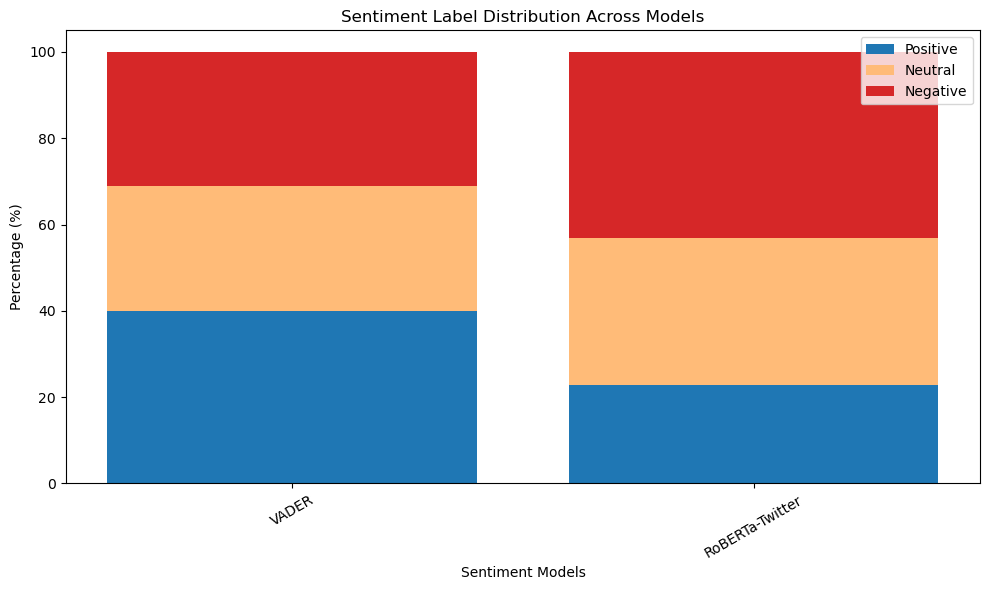

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ File paths for datasets
file_paths = {
    "Gameplay": "datasets/__sprint2_filtered_gameplay_review_set_with_sentiment_scores_standardized.csv",
    "Functionality": "datasets/__sprint2_filtered_functionality_review_set_with_sentiment_scores_standardized.csv",
    "Usability": "datasets/__sprint2_filtered_usability_review_set_with_sentiment_scores_standardized.csv",
}

# ✅ Define sentiment models
model_names = ["VADER", "RoBERTa-Twitter"]
sentiment_labels = ["Positive", "Neutral", "Negative"]

# ✅ Initialize sentiment distributions
sentiment_distributions = {model: {label: [] for label in sentiment_labels} for model in model_names}

# ✅ Read data and compute sentiment label distributions per category
for category, file_path in file_paths.items():
    df = pd.read_csv(file_path)

    for model in model_names:
        label_column = f"{model}_sentiment"
        if label_column in df.columns:
            sentiment_counts = df[label_column].value_counts(normalize=True).to_dict()

            # Ensure all labels exist in dictionary
            for label in sentiment_labels:
                sentiment_distributions[model][label].append(sentiment_counts.get(label, 0))

# ✅ Convert sentiment distributions into a NumPy array (ensuring uniform shape)
sentiment_matrix = {
    label: np.array([sum(sentiment_distributions[model][label]) / len(file_paths) for model in model_names]) * 100
    for label in sentiment_labels
}

# ✅ Create Stacked Bar Chart for Sentiment Label Distributions
fig, ax = plt.subplots(figsize=(10, 6))
bottom_stack = np.zeros(len(model_names))  # Start stacking from 0

colors = ["#1f77b4", "#ffbb78", "#d62728"]  # Colors for Positive, Neutral, Negative

for i, label in enumerate(sentiment_labels):
    ax.bar(model_names, sentiment_matrix[label], bottom=bottom_stack, color=colors[i], label=label)
    bottom_stack += sentiment_matrix[label]  # Update stack height

# ✅ Adjust visualization details
ax.set_ylabel("Percentage (%)")
ax.set_xlabel("Sentiment Models")
ax.set_title("Sentiment Label Distribution Across Models")
ax.legend(loc="upper right")

# ✅ Save and show the stacked bar chart
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("sentiment_distribution_bar_chart_fixed.png")
plt.show()


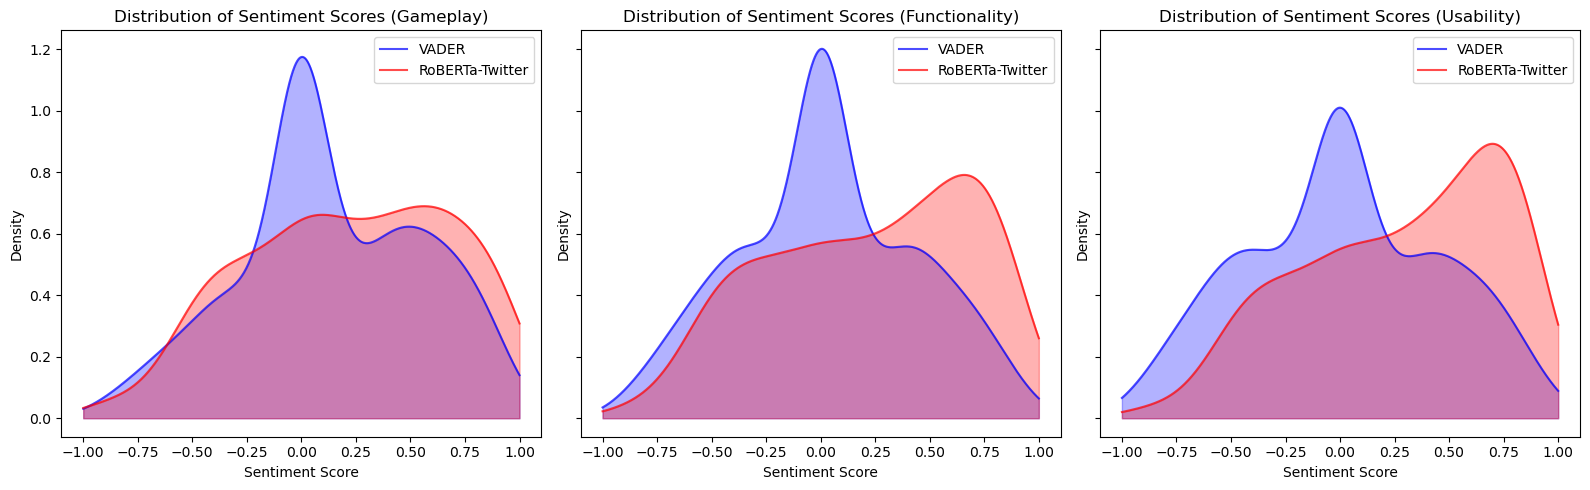

In [13]:
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ✅ File paths for datasets
file_paths = {
    "Gameplay": "datasets/__sprint2_filtered_gameplay_review_set_with_sentiment_scores_standardized.csv",
    "Functionality": "datasets/__sprint2_filtered_functionality_review_set_with_sentiment_scores_standardized.csv",
    "Usability": "datasets/__sprint2_filtered_usability_review_set_with_sentiment_scores_standardized.csv",
}

# ✅ Define sentiment models
model_names = ["VADER", "RoBERTa-Twitter"]

# ✅ Load and sample data
sample_size = len(df) # 200  # Adjust sample size as needed

sampled_data = {}
for category, file_path in file_paths.items():
    df = pd.read_csv(file_path)
    sampled_data[category] = df #sampled_data[category]
    #sampled_data[category] = df.sample(min(sample_size, len(df)), replace=False)  # Ensure we don't exceed available rows

# ✅ Combine sampled data into a single DataFrame
df_combined = pd.concat(sampled_data.values(), keys=sampled_data.keys())

# ✅ Generate KDE plots for sentiment distributions
fig, axs = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True)
chart_titles = [
    "Distribution of Sentiment Scores (Gameplay)",
    "Distribution of Sentiment Scores (Functionality)",
    "Distribution of Sentiment Scores (Usability)"
]

# ✅ Loop through datasets and create KDE plots
for index, (ax, (category, df)) in enumerate(zip(axs, sampled_data.items())):
    x_vals = np.linspace(-1, 1, 1000)
    colors = ["blue", "red"]

    for model, color in zip(model_names, colors):
        score_column = f"{model}_score_standardized"
        if score_column in df.columns:
            clean_data = df[score_column].dropna()
            if len(clean_data.unique()) > 1:
                kde = gaussian_kde(clean_data, bw_method=0.3)
                y_vals = kde(x_vals)
                ax.plot(x_vals, y_vals, label=model, color=color, alpha=0.7)
                ax.fill_between(x_vals, y_vals, alpha=0.3, color=color)
            else:
                print(f"Skipping KDE for {category} - {model} due to insufficient unique values.")

    # ✅ Labels and title for each subplot
    ax.set_xlabel("Sentiment Score")
    ax.set_ylabel("Density")
    ax.set_title(chart_titles[index])
    ax.legend()

# ✅ Adjust layout and show plot
plt.tight_layout()
plt.savefig("sentiment_model_comparison_kde.png")
plt.show()


Sample Comparison of Manual Labels vs Model Predictions:
Empty DataFrame
Columns: [tokenized_sentence, manual_label, VADER_sentiment, RoBERTa-Twitter_sentiment]
Index: []

Model Accuracy Comparison:
             Model  Accuracy
0            VADER       NaN
1  RoBERTa-Twitter       NaN


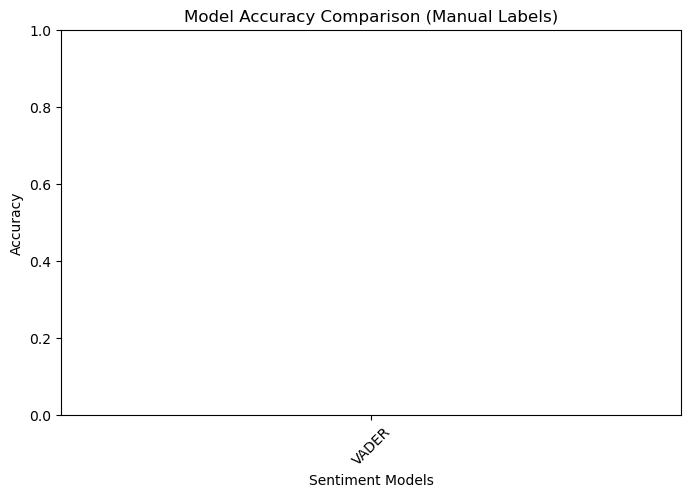

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to load labeled dataset and compare results
def compare_manual_labels(file_path):
    # Load manually labeled dataset
    manual_labeled_df = pd.read_csv(file_path)

    # Merge manual labels with original dataset for comparison
    comparison_df = df.merge(manual_labeled_df, on="tokenized_sentence", how="inner")

    # Ensure correct column naming for comparison
    comparison_df.rename(columns={
        "VADER_sentiment_x": "VADER_sentiment",
        "RoBERTa-Twitter_sentiment_x": "RoBERTa-Twitter_sentiment",
        "manual_label_y": "manual_label"
    }, inplace=True)

    # Compare manual labels with model predictions
    comparison_df["VADER_correct"] = comparison_df["VADER_sentiment"] == comparison_df["manual_label"]
    comparison_df["RoBERTa-Twitter_correct"] = comparison_df["RoBERTa-Twitter_sentiment"] == comparison_df["manual_label"]

    # Calculate accuracy for both models against manual labels
    accuracy_results = {
        "VADER": comparison_df["VADER_correct"].mean(),
        "RoBERTa-Twitter": comparison_df["RoBERTa-Twitter_correct"].mean()
    }

    # Convert to DataFrame for better visualization
    accuracy_df = pd.DataFrame(accuracy_results.items(), columns=["Model", "Accuracy"])

    # Print comparison results
    print("Sample Comparison of Manual Labels vs Model Predictions:")
    print(comparison_df[["tokenized_sentence", "manual_label", "VADER_sentiment", "RoBERTa-Twitter_sentiment"]].head(10))

    # Print accuracy results
    print("\nModel Accuracy Comparison:")
    print(accuracy_df)

    # Plot accuracy comparison
    plt.figure(figsize=(8, 5))
    plt.bar(accuracy_results.keys(), accuracy_results.values(), color=['blue', 'red'])
    plt.xlabel("Sentiment Models")
    plt.ylabel("Accuracy")
    plt.title("Model Accuracy Comparison (Manual Labels)")
    plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
    plt.xticks(rotation=45)
    plt.show()


# Example usage: Call function with the uploaded file
compare_manual_labels("datasets/Manual_Sentiment_Labeling__Informative___1_labeled.csv")